## About
License Plate Text Recognition in PyTorch

Dataset Link - https://www.kaggle.com/datasets/nickyazdani/license-plate-text-recognition-dataset?select=lpr.csv

In [1]:
#importing libraries
import pandas as pd
import glob
import cv2
from PIL import Image
import os
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import string
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import CTCLoss
import torch.optim as optim

%matplotlib inline

In [2]:
dataset_path = "/home/suraj/ClickUp/Jan-Feb/data/cropped_lps/cropped_lps"

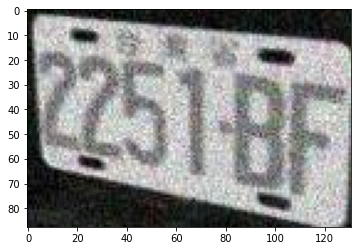

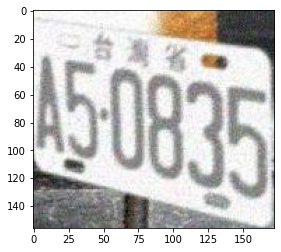

In [3]:
#visualising few images from the directory
disp_counter=0
for file_name in glob.glob(dataset_path+"/*.jpg"):
    img = cv2.imread(file_name)
    plt.imshow(img)
    plt.show()
    disp_counter+=1
    if disp_counter==2:
        break

In [4]:
# creating dataset
class VehicleDataset(Dataset):
    def __init__(self,dataset_path, transform=None):
        self.dataset_path = dataset_path
        self.transform = transform
        self.images,self.labels = [],[]
        for file_name in glob.glob(dataset_path+"cropped_lps/cropped_lps/*.jpg"):
            self.images.append(Image.open(file_name))
            label_id = file_name.split('/')[-1]
            labels_mapper = pd.read_csv(dataset_path+"lpr.csv")
            index = labels_mapper.loc[labels_mapper['images']==label_id].index
            self.labels.append(labels_mapper['labels'][index].values[0])
     

    def __len__(self):
        return len(self.labels)

    def __getitem__(self,index):
        img = self.images[index]
        label = self.labels[index]
        if self.transform is not None:
            img = self.transform(img)
        
        item = {'img':img, 'label':label}
        return item
        

In [5]:
#creating a collate function #optional that could other wise do padding
class Collater(object):

    def __init__(self,arg=None):
        self.arg = arg
    
    def __call__(self, batch):
        for b in batch:
            img,label = b['img'],b['label']

        item = {}
        item['img'] = img
        item['label'] = label
        return item
        

In [6]:
dataset_path = "/home/suraj/ClickUp/Jan-Feb/data/"
transform = transforms.Compose([transforms.ToTensor(),transforms.Resize((100,32)), transforms.Grayscale(num_output_channels=1)])
train_data = VehicleDataset(dataset_path=dataset_path,transform=transform) #alternatively,arg=transforms =transform instead of collate_fn can be passsed.


tensor([[[0.0604, 0.0332, 0.0317,  ..., 0.0905, 0.0452, 0.0543],
         [0.0498, 0.1182, 0.0757,  ..., 0.1092, 0.1033, 0.0786],
         [0.1003, 0.4045, 0.3544,  ..., 0.0933, 0.1142, 0.0894],
         ...,
         [0.1249, 0.1389, 0.1765,  ..., 0.8124, 0.8235, 0.3754],
         [0.1198, 0.0940, 0.1490,  ..., 0.7080, 0.7931, 0.2657],
         [0.1137, 0.0346, 0.0442,  ..., 0.7767, 0.6823, 0.1608]]]) 2251BF
torch.float32


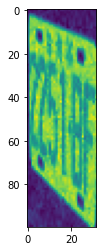

tensor([[[0.9840, 0.9748, 0.9748,  ..., 0.2389, 0.2279, 0.2249],
         [0.9643, 0.9654, 0.9771,  ..., 0.2535, 0.2164, 0.2258],
         [0.9785, 0.9720, 0.9646,  ..., 0.2564, 0.2396, 0.2125],
         ...,
         [0.3010, 0.3556, 0.3795,  ..., 0.9460, 0.9719, 0.7111],
         [0.3115, 0.3200, 0.3573,  ..., 0.8466, 0.9117, 0.6497],
         [0.2905, 0.2989, 0.3698,  ..., 0.6098, 0.7352, 0.6116]]]) A50835
torch.float32


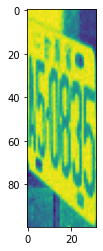

tensor([[[0.1868, 0.3246, 0.2422,  ..., 0.1557, 0.1557, 0.1675],
         [0.2155, 0.4421, 0.3721,  ..., 0.1557, 0.1557, 0.1660],
         [0.2570, 0.5430, 0.4977,  ..., 0.1557, 0.1557, 0.1645],
         ...,
         [0.1766, 0.1833, 0.1777,  ..., 0.7215, 0.4400, 0.1755],
         [0.1777, 0.1850, 0.1777,  ..., 0.7496, 0.3975, 0.1707],
         [0.1789, 0.1850, 0.1803,  ..., 0.7580, 0.3663, 0.1680]]]) Y98462
torch.float32


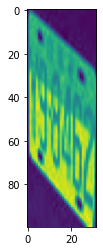

In [7]:
for i,batch in enumerate(train_data):
    print(batch['img'], batch['label'])
    print(batch['img'].dtype)
    plt.imshow(batch['img'][0])
    plt.show()
    if i==2:
        break

In [ ]:
#creating data loader
batch_size=8
dataloader = DataLoader(train_data, batch_size=8, shuffle=True, num_workers=4, collate_fn=Collater())

In [ ]:
for batch in dataloader:
    print(batch)
    break

In [10]:
alphabets = string.ascii_uppercase + string.digits
print(alphabets)

ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789


In [11]:
# Util functions for converting string label
class strLabelConverter(object):
    """ Class for converting str and label
    blank should be inserted to the alphabets for CTC
    ignoring case = True, since number plate's char is upper case
    """
    def __init__(self,alphabet, ignore_case=True):
        self.ignore_case =ignore_case
        
        self.alphabet = alphabet + '-' # at last index
        self.dict = {}
        for i, char in enumerate(alphabet):
            self.dict[char]=i+1

    #encoding 
    def encode(self,text):
        length = []
        result = []
        for item in text:
            item = item.encode().decode('utf-8','strict')
            length.append(len(item))
            r = []
            for char in item:
                index = self.dict[char]
                r.append(index)
            result.append(r)
            #converting each char to their relative numbers
        
        max_len =0
        for r in result:
            if len(r)>max_len:
                max_len = len(r)
        
        result_temp = []
        for r in result:
            for i in range(max_len - len(r)):
                r.append(0)
            result_temp.append(r)
        
        text = result_temp
        return (torch.LongTensor(text), torch.LongTensor(length))
        # since CTC expects long tensor of encoded text and its seq_length
        # [a,b,c], len = [0,1,2], [3]
    #decoding

    def decode(self, t, length, raw=False):
        '''
        Decode encoded texts back into strs
        '''
        if length.numel() == 1:
            length = length[0]
            assert t.numel() == length, "text with length: {} does not match declared length: {}".format(t.numel(), length)
            if raw:
                return ''.join([self.alphabet[i - 1] for i in t])
            else:
                char_list = []
                for i in range(length):
                    if t[i] != 0 and (not (i > 0 and t[i - 1] == t[i])):
                        char_list.append(self.alphabet[t[i] - 1])
                return ''.join(char_list)
        else:
            # batch mode
            assert t.numel() == length.sum(), "texts with length: {} does not match declared length: {}".format(t.numel(), length.sum())
            texts = []
            index = 0
            for i in range(length.numel()):
                l = length[i]
                texts.append(
                    self.decode(
                        t[index:index + l], torch.LongTensor([l]), raw=raw))
                index += l
            return texts


    

In [12]:
#function to one hot
def one_hot(text, text_length, nc):
    batch_size = text_length.size(0)
    maxLength = text_length.max()
    onehot = torch.FloatTensor(batch_size,maxLength, nc).fill_(0)
    acc = 0
    for i in range(batch_size):
        length = text_length[i]
        label = text[acc:acc+length].view(-1,1).long()
        one_hot[i,:length].scatter_(1,label,1.0)
        acc+=length
    
    return one_hot

In [13]:
# CRNN model -https://github.com/meijieru/crnn.pytorch/blob/master/models/crnn.py
class BidirectionalLSTM(nn.Module):

    def __init__(self, nIn, nHidden, nOut):
        super(BidirectionalLSTM, self).__init__()

        self.rnn = nn.LSTM(nIn, nHidden, bidirectional=True)
        self.embedding = nn.Linear(nHidden * 2, nOut)

    def forward(self, input):
        recurrent, _ = self.rnn(input)
        T, b, h = recurrent.size()
        t_rec = recurrent.view(T * b, h)

        output = self.embedding(t_rec)  # [T * b, nOut]
        output = output.view(T, b, -1)

        return output


class CRNN(nn.Module):

    def __init__(self, imgH, nc, nclass, nh, n_rnn=2, leakyRelu=False):
        super(CRNN, self).__init__()
        assert imgH % 16 == 0, 'imgH has to be a multiple of 16'

        ks = [3, 3, 3, 3, 3, 3, 2]
        ps = [1, 1, 1, 1, 1, 1, 0]
        ss = [1, 1, 1, 1, 1, 1, 1]
        nm = [64, 128, 256, 256, 512, 512, 512]

        cnn = nn.Sequential()

        def convRelu(i, batchNormalization=False):
            nIn = nc if i == 0 else nm[i - 1]
            nOut = nm[i]
            cnn.add_module('conv{0}'.format(i),
                           nn.Conv2d(nIn, nOut, ks[i], ss[i], ps[i]))
            if batchNormalization:
                cnn.add_module('batchnorm{0}'.format(i), nn.BatchNorm2d(nOut))
            if leakyRelu:
                cnn.add_module('relu{0}'.format(i),
                               nn.LeakyReLU(0.2, inplace=True))
            else:
                cnn.add_module('relu{0}'.format(i), nn.ReLU(True))

        convRelu(0)
        cnn.add_module('pooling{0}'.format(0), nn.MaxPool2d(2, 2))  # 64x16x64
        convRelu(1)
        cnn.add_module('pooling{0}'.format(1), nn.MaxPool2d(2, 2))  # 128x8x32
        convRelu(2, True)
        convRelu(3)
        cnn.add_module('pooling{0}'.format(2),
                       nn.MaxPool2d((2, 2), (2, 1), (0, 1)))  # 256x4x16
        convRelu(4, True)
        convRelu(5)
        cnn.add_module('pooling{0}'.format(3),
                       nn.MaxPool2d((2, 2), (2, 1), (0, 1)))  # 512x2x16
        convRelu(6, True)  # 512x1x16

        self.cnn = cnn
        self.rnn = nn.Sequential(
            BidirectionalLSTM(512, nh, nh),
            BidirectionalLSTM(nh, nh, nclass))


    def forward(self, input):
        # conv features
        conv = self.cnn(input)
        b, c, h, w = conv.size()
        assert h == 1, "the height of conv must be 1"
        conv = conv.squeeze(2)
        conv = conv.permute(2, 0, 1)  # [w, b, c]

        # rnn features
        output = self.rnn(conv)
        
        # add log_softmax to converge output
        output = F.log_softmax(output, dim=2)

        return output


    def backward_hook(self, module, grad_input, grad_output):
        for g in grad_input:
            g[g != g] = 0

In [14]:
n_class = len(alphabets)+1

crnn = CRNN(imgH=32,nc=1, nclass=n_class,nh=256) # nc = num channel nh = size of lstm hidden state

In [15]:
crnn

CRNN(
  (cnn): Sequential(
    (conv0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu0): ReLU(inplace=True)
    (pooling0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU(inplace=True)
    (pooling1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batchnorm2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu3): ReLU(inplace=True)
    (pooling2): MaxPool2d(kernel_size=(2, 2), stride=(2, 1), padding=(0, 1), dilation=1, ceil_mode=False)
    (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batchnorm4): BatchNorm2d(512, eps=1e-05, momentum=0.

In [16]:
# initialising weights
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [17]:
crnn.apply(weights_init)

CRNN(
  (cnn): Sequential(
    (conv0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu0): ReLU(inplace=True)
    (pooling0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU(inplace=True)
    (pooling1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batchnorm2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu3): ReLU(inplace=True)
    (pooling2): MaxPool2d(kernel_size=(2, 2), stride=(2, 1), padding=(0, 1), dilation=1, ceil_mode=False)
    (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batchnorm4): BatchNorm2d(512, eps=1e-05, momentum=0.

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [19]:
for param in crnn.parameters():
    param.requires_grad = True

In [20]:
crnn = crnn.to(device)

In [21]:
encoder_decoder = strLabelConverter(alphabet=alphabets)

In [22]:
optimizer = optim.Adam(crnn.parameters(), lr=0.01)
criterion = CTCLoss()



In [ ]:
# trainiing
crnn.train()
num_epochs=10
for epoch in range(num_epochs):
    for i,batch in enumerate(dataloader):
        img,label = batch['img'],batch['label']
        img = img.unsqueeze(0)
        print(img.shape)
        batch_size = img.size(0)
        text,len = encoder_decoder.encode(label)
        text = text.to(device)
        len = len.to(device)
        pred = crnn(img)
        optimizer.zero_grad()
        preds_size = torch.LongTensor([pred.size(0)]* batch_size)
        loss = criterion(pred,text, preds_size,len)/batch_size
        loss.backward()
        optimizer.step()
    
    print("Epoch - {}, Loss - {}".format(epoch, loss()))


In [ ]:
,